Code used from this link:

https://medium.com/technonerds/using-fastais-ulmfit-to-make-a-state-of-the-art-multi-label-text-classifier-bf54e2943e83

GitHub Link: 
https://github.com/aditya10/ULMFiT-fastai-text-classifier/blob/master/ULMFiT_tutorial.ipynb



In [1]:
#code needed to use colab notebook
#if you're using juptyer notebook then skip this line
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from fastai.text import *
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

###Model set-up

In [3]:
#cd needed for colab
%cd "gdrive/My Drive/Colab Notebooks"
#%cd ..
!ls

/content/gdrive/My Drive/Colab Notebooks
 20200504-193926_joe_biden_nlp_subs_clean.csv
 20200504-193926_joe_biden_nlp_subs_clean_expanded.csv
 20200504-193926_joe_biden_nlp_subs.csv
'20200625-155513_gun_control (1).csv'
 20200625-155513_gun_control_nlp.csv
 20200625-155513_gun_control_nlp_subs_clean.csv
 20200625-155513_gun_control_nlp_subs_clean_expanded.csv
 20200625-155513_gun_control_nlp_subs.csv
 black_lives_nlp_subs_clean_expanded.csv
 Extract_subtitles.ipynb
 models
 nlp_EDA_v3.ipynb
 nlp_EDA_v4.ipynb
 nlp_model_training_v2.ipynb
 pandemic_nlp_subs_clean_expanded.csv


In [4]:
# load train_cleaned.csv

filename = "20200625-155513_gun_control_nlp_subs_clean_expanded.csv"

df = pd.read_csv(filename, index_col=0)


In [5]:
df.head(2)

,bias_num,text
0,0,Dawkins is famous as the author of Selfish Ge...
1,0,ink the rules of the game should be between a ...


In [7]:
#length of dataset
print(f'Length of dataset is: {len(df)}')

#percentage of videos that are right
pr_right = round(df['bias_num'].mean()*100,2)
print(f'Percentage of videos that are right: {pr_right} %')

Length of dataset is: 856
Percentage of videos that are right: 2.92 %


In [8]:
#combine columns. Fastai only works with 1 text column
#train_language['text'] = train_language['title'] + " " + train_language['description']

In [9]:
#create train and test split
df_trn, df_val = train_test_split(df, stratify = df['bias_num'], test_size = 0.3, random_state=42)
df_trn.shape, df_val.shape

((599, 2), (257, 2))

### Pre-processing language model

In [10]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [11]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [12]:
# check out data
data_clas.show_batch()

text,target
"xxbos xxup xxunk xxup you xxup or xxup who xxup they xxup said xxup they xxup called xxup you xxup or xxup who xxup they xxup said xxup they xxup were , xxup but xxup wasn’t xxup us . xxup were , xxup but xxup wasn’t xxup us . xxup did xxup you xxup really xxup think xxup it xxup was xxup us ? xxup did xxup you xxup really",0
"xxbos c xxup about xxup it . xxup he xxup has xxup the xxup need xxup to xxup be xxup the xxup xxunk xxup male , xxup the xxup idea xxup most xxup people xxup dont xxup know xxup this xxup is xxup coming xxup from xxup the xxup same xxup well . xxup the xxup idea xxup is xxup hes xxup always xxup the xxup one xxup whos xxup",0
xxbos e xxup purple xxup there . xxup the xxup purple xxup there . xxup that xxup ’s xxup the xxup leader xxup of xxup india xxup in xxup that xxup ’s xxup the xxup leader xxup of xxup india xxup in xxup the xxup black . xxup the xxup black . xxup the xxup indian xxup and xxup german xxup leaders xxup the xxup indian xxup and xxup german,0
xxbos xxup country xxup per xxup xxunk . xxup you xxup can xxup just xxup pay xxup don xxup junior xxup at xxup you xxup can xxup just xxup pay xxup don xxup junior xxup at xxup the xxup door xxup or xxup ivanka . xxup the xxup door xxup or xxup ivanka . xxup let xxup ’s xxup make xxup this xxup easy . xxup let xxup ’s xxup,0
xxbos xxup se xxup of xxup language xxup xxunk . xxup hes xxup quick xxup to xxup xxunk xxup us xxup he xxup went xxup to xxup the xxup best xxup schools . > > xxup and xxup learned xxup nothing xxup in xxup them . xxup he xxup speaks xxup like xxup one xxup who xxup paid xxup no xxup education xxup to xxup one xxup of xxup the,0


In [13]:
#data_clas.save("/content/gdrive/My Drive/language_models/databunch/TextClasDataBunch.pkl") 

In [14]:
#data_lm.save("/content/gdrive/My Drive/language_models/databunch/TextLMDataBunch.pkl")

### Language model

In [15]:
# train language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [16]:
# let’s use this learning rate to train the language model
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.915823,4.613410,0.220845,00:10
1,4.858818,4.486200,0.229962,00:10
2,4.755944,4.354337,0.236813,00:10
3,4.626717,4.264276,0.242411,00:10
4,4.514040,4.203196,0.246257,00:10
5,4.411427,4.164031,0.249536,00:10
6,4.331241,4.141974,0.252163,00:10
7,4.274168,4.128728,0.252421,00:11
8,4.232239,4.126690,0.253005,00:11
9,4.206404,4.124950,0.253503,00:11


In [17]:
# unfreezing weights and training the rest of the NN
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.074658,3.954576,0.273918,00:13
1,3.871193,3.919130,0.277627,00:13


In [18]:
#save the language model encoder so that we can load it later in our classifier
learn.save_encoder("ft_enc")

### Classification

In [19]:
#set-up classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy])
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (599 items)
x: TextList
xxbos xxunk if you can make people think as well as laughs because a lot laughs easy i could fall over and you d laugh right thanks a lot in fact one of you would film it youtube i imagine him or and 20 pounds so i i think that um comedy is best probably is is clever but then there s something very nice and visceral and you know it is funny to see someone fall over you know i mean that i m sort of xxunk but you know xxunk love xxmaj lauren xxmaj hardy and what was nice about them was the the sort of relationship that was so xxunk and there we were laughing their situation to xxunk of one and the the guy who did nt care but the guy did nt care the xxunk guy who thought that he was xxunk than the other one he always ended up down you know face down in the duck pond so i think if you analyze most comedy there s there s there s something clever in it there s another layer as opposed to it just looking at youtube c

In [20]:
#train classifier for 10 epochs
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.738423,0.500717,0.968872,00:09
1,0.681855,0.436037,0.937743,00:09
2,0.621493,0.392362,0.941634,00:09
3,0.542882,0.327636,0.949416,00:09
4,0.449491,0.221253,0.972763,00:09
5,0.355935,0.121088,1.000000,00:09
6,0.276770,0.118909,0.968872,00:09
7,0.216260,0.093469,0.992218,00:09
8,0.169063,0.074420,0.996109,00:09
9,0.137922,0.072653,1.000000,00:09


In [21]:
#save model weights
#learn.save('language_classifier')

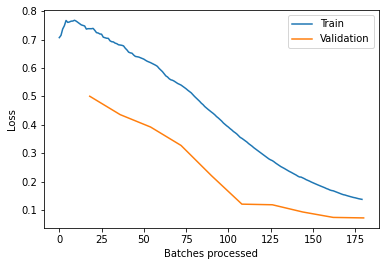

In [22]:
#inspect losses.
learn.recorder.plot_losses()

In [23]:
# unfreezing weights and training the rest of the NN
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.064614,0.085610,0.996109,00:10
1,0.068268,0.064922,0.980545,00:10
2,0.053575,0.041148,0.984436,00:10
3,0.043613,0.038764,0.992218,00:10


In [24]:
#export language classifier for prediction
#learn.export(file = "nlp_export.pkl")

###Confusion matrix

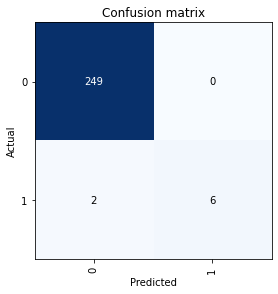

In [25]:
# create confusion matrix
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()